# Training GANCA-3D

## Downloads

In [1]:
# enable pytorch tpu spport on colab
# !pip --quiet install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl
# !pip --quiet install torch==1.9 torchtext==0.10 torchvision==0.10 torchaudio==0.9

In [2]:
# !wget -q https://github.com/chaosarium/3D-GANCA/raw/master/data_helper.py
# !wget -q https://github.com/chaosarium/3D-GANCA/raw/master/utils.py
# !wget -q https://github.com/chaosarium/3D-GANCA/raw/master/models.py
# !wget -q https://github.com/chaosarium/3D-GANCA/raw/master/block_ids_alt.tsv
# !wget -q https://github.com/chaosarium/3D-GANCA/raw/master/output.zip
# !unzip -q output.zip
# !mkdir dataset
# !wget -q https://github.com/chaosarium/3D-GANCA/blob/master/dataset/filtered_houses_stats.pkl4 -O dataset/filtered_houses_stats.pkl4
# !wget -q https://github.com/chaosarium/3D-GANCA/blob/master/dataset/filtered_houses_stats.pkl -O dataset/filtered_houses_stats.pkl

In [3]:
# !pip --quiet install torchsummaryX loguru einops pytorch_lightning

## Imports

In [147]:
# import stuff

import data_helper
from data_helper import GANCA3DDataModule
from models import VoxelPerceptionNet, VoxelUpdateNet, VoxelNCAModel, VoxelDiscriminator
import visualise_helper
import utils
%load_ext autoreload
%autoreload 2

import numpy as np
import sys
import torch
import random
from torchsummaryX import summary
import matplotlib.pyplot as plt
from pytorch_lightning import Trainer
import pytorch_lightning as pl

from loguru import logger as gurulogger
gurulogger.remove()
gurulogger.add(sys.stdout, colorize=True, format="<blue>{time}</blue> <level>{message}</level>")
gurulogger.level("INFO", color="<red><bold>")

import os
from einops import rearrange
import torch.nn.functional as F
import pandas as pd

BLOCK2VEC_OUT_PATH = 'output/block2vec saves/block2vec 64 dim locked air/'
NUM_WORKERS = int(os.cpu_count() / 2)

%load_ext tensorboard

if torch.cuda.is_available():
    print('CUDNN VERSION:', torch.backends.cudnn.version())
    print('Number CUDA Devices:', torch.cuda.device_count())
    print('CUDA Device Name:',torch.cuda.get_device_name(0))
    print('CUDA Device Total Memory [GB]:',torch.cuda.get_device_properties(0).total_memory/1e9)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [213]:
embedding, mcid2block, block2embeddingidx, embeddingidx2block, block2mcid = utils.get_embedding_info(BLOCK2VEC_OUT_PATH)
air_embedding = embedding(torch.tensor(block2embeddingidx['minecraft:air']))
air_embedding

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [215]:
def embeddingidx2blockidx(embeddingidx):
    block_name = embeddingidx2block[embeddingidx]
    blockid = block2mcid[block_name]
    return blockid
vectorised_embeddingidx2blockidx = np.vectorize(embeddingidx2blockidx)

In [ ]:
# %tensorboard --logdir lightning_logs/

## MM GAN

In [3]:
class GANCA_MMGAN(pl.LightningModule):

    def __init__(self,
            lr = 2e-4,
            beta1 = 0.9,
            beta2 = 0.999,
            batch_size = 16,
            num_embedding_channels = 64,
            num_hidden_channels = 63,
            update_net_channel_dims = [32, 32],
            embedding: torch.nn.Embedding = None,
            step_range = [16, 20],
        ):
        
        super().__init__()
        # call this to save args to the checkpoint
        self.save_hyperparameters()
        
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.batch_size = batch_size
        self.num_embedding_channels = num_embedding_channels
        self.num_hidden_channels = num_hidden_channels
        self.update_net_channel_dims = update_net_channel_dims
        # the channels will be like [alpha, embeddings ... , hiddens ...]
        self.num_channels = 1 + self.num_embedding_channels + self.num_hidden_channels
        self.world_size = (32,32,32)
        self.embedding = embedding
        self.embedding.weight.requires_grad=False # freeze embeddings
        self.step_range = step_range
        
        self.generator = VoxelNCAModel(
            alpha_living_threshold = 0.1,
            cell_fire_rate = 0.5,
            num_perceptions = 3,
            perception_requires_grad = True,
            num_embedding_channels = self.num_embedding_channels,
            num_hidden_channels = self.num_hidden_channels,
            normal_std = 0.0002,
            use_normal_init = True,
            zero_bias = True,
            update_net_channel_dims = self.update_net_channel_dims,
        )
        self.discriminator = VoxelDiscriminator(
            num_in_channels = self.num_embedding_channels, 
            use_sigmoid=True,
        )
        
        # generate some random seeds (N, channels, x, y, z)
        self.validation_noise = self.make_seed_states(16)
        
    def make_seed_states(self, batch_size):
        return utils.make_seed_state(
            batch_size = batch_size,
            num_channels = self.num_channels, 
            alpha_channel_index = 0,
            seed_dim = (4, 4, 4), 
            world_size = self.world_size,
        )
    
    def training_step(self, batch, batch_idx, optimizer_idx):
        
        num_steps = random.randint(*self.step_range)
            
        real_houses = batch
        type_holder = batch[0,0,0,0].to(torch.float) # this is a dummy type for creating labels
        size_this_batch = real_houses.shape[0]
                
        # make noise
        
        seed_states = self.make_seed_states(size_this_batch).type_as(type_holder) # same batch size as those coming in
            
        # train generator
        if optimizer_idx == 0:
            
            # generate images
            fake_houses_states = self.generator.forward(seed_states, steps=num_steps)
                        
            # create ground truth result (all fake results) we want D to say the generated ones are real so they are all 1s
            real_labels = utils.make_real_labels(size_this_batch).type_as(type_holder)
            
            # now get the embedding parts out of the fake states
            fake_houses = fake_houses_states[:, 1:self.num_embedding_channels+1, :, :, :]
            
            # see what discriminator thinks
            fake_predictions = self.discriminator.forward(fake_houses)
            
            # calculate loss
            g_loss = F.binary_cross_entropy(fake_predictions, real_labels) # y_hat, y  
                                    
            self.log("g_loss", g_loss.detach(), prog_bar=True, logger=True)

            return g_loss
        
        if optimizer_idx == 1:
            
            # get embeddings for the real house
            real_houses = utils.examples2embedding(real_houses, self.embedding)
            
            # pass in real image to D and try to make it predict all 1s
            real_targets = utils.make_real_labels(size_this_batch).type_as(type_holder)
            real_predictions = self.discriminator.forward(real_houses)
            real_loss = F.binary_cross_entropy(real_predictions, real_targets)
            # TODO fix accuracy formula
            real_acc = torch.mean(real_predictions).item() # the average prediction. The closer to 1 the more accurate
            
            # meanwhile, we also want D to be able to tell that outputs from G are all fake
            fake_targets = utils.make_fake_labels(size_this_batch).type_as(type_holder)
            fake_houses_states = self.generator.forward(seed_states, steps=num_steps).detach() # detach so that gradients don't pass back into generator
            fake_houses = fake_houses_states[:, 1:self.num_embedding_channels+1, :, :, :] # extract the embedding parts
            fake_predictions = self.discriminator.forward(fake_houses)
            fake_loss = F.binary_cross_entropy(fake_predictions, fake_targets)
            # TODO fix accuracy formula
            fake_acc = 1 - torch.mean(fake_predictions).item() # the 1 - average prediction. The closer to 1 the more accurate
                        
            # discriminator loss is the average of the two losses
            d_loss = (real_loss + fake_loss) / 2
            avg_acc = (real_acc + fake_acc) / 2
                    
            self.log("fake_loss", fake_loss.detach(), prog_bar=False, logger=True)
            self.log("real_loss", real_loss.detach(), prog_bar=False, logger=True)
            self.log("d_loss", d_loss.detach(), prog_bar=True, logger=True)
            self.log("real_acc", real_acc, prog_bar=False, logger=True)
            self.log("fake_acc", fake_acc, prog_bar=False, logger=True)
            self.log("avg_acc", avg_acc, prog_bar=True, logger=True)

            return d_loss

    def configure_optimizers(self,):
        # define pytorch optimizers here. return [list of optimizers], [list of LR schedulers]
        g_optimizer = torch.optim.Adam(self.generator.parameters(), lr=self.lr, betas=(self.beta1, self.beta2))
        d_optimizer = torch.optim.Adam(self.discriminator.parameters(), lr=self.lr, betas=(self.beta1, self.beta2))
        return [g_optimizer, d_optimizer], []

In [ ]:
model = GANCA_MMGAN(
    lr = 2e-4,
    beta1 = 0.9,
    beta2 = 0.999,
    batch_size = 8,
    num_embedding_channels = 64,
    num_hidden_channels = 63,
    update_net_channel_dims = [16, 16],
    embedding = embedding,
    step_range = [16, 20],
)

In [ ]:
dm = GANCA3DDataModule(batch_size=8, num_workers=1, mcid2block = mcid2block, block2embeddingid = block2embeddingidx, debug=False)
dm.prepare_data()
dm.setup()

Dataset already exists


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


  0%|          | 0/1977 [00:00<?, ?it/s]

loaded 1977 houses
Turning MC id into embedding idx. This could take up to a minute.


In [ ]:
logger = pl.loggers.TensorBoardLogger(save_dir='lightning_logs', name='GANCA', default_hp_metric=False)
trainer = Trainer(gpus=1, max_epochs=1, fast_dev_run=False, log_every_n_steps=1, logger=logger, profiler="simple")

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [ ]:
trainer.fit(model, dm)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/configuration_validator.py:120: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:470: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  f"DataModule.{name} has already been called, so it will not be called again. "
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Missing logger folder: lightning_logs/GANCA

  | Name          | Type               | Params
-----------------------------------------------------
0 | embedding     | Embedding          | 14.0 K
1 | generator     | VoxelNCAModel      | 18.8 K
2 | discriminator | VoxelDiscriminator | 11.3 M
---------------------------------------

Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:688: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


## WGAN

In [28]:
class GANCA_WGAN(pl.LightningModule):

    def __init__(self,
            lr = 2e-4,
            # beta1 = 0.9,
            # beta2 = 0.999,
            weight_clip = 0.01, # glipping gradient in WGAN
            batch_size = 16,
            num_embedding_channels = 64,
            num_hidden_channels = 63,
            update_net_channel_dims = [32, 32],
            embedding: torch.nn.Embedding = None,
            step_range = [16, 20],
        ):
        
        super().__init__()
        # call this to save args to the checkpoint
        self.save_hyperparameters()
        
        self.lr = lr
        self.weight_clip = weight_clip
        # self.beta1 = beta1
        # self.beta2 = beta2
        self.batch_size = batch_size
        self.num_embedding_channels = num_embedding_channels
        self.num_hidden_channels = num_hidden_channels
        self.update_net_channel_dims = update_net_channel_dims
        # the channels will be like [alpha, embeddings ... , hiddens ...]
        self.num_channels = 1 + self.num_embedding_channels + self.num_hidden_channels
        self.world_size = (32,32,32)
        self.seed_size = (2,2,2)
        self.embedding = embedding
        self.embedding.weight.requires_grad=False # freeze embeddings
        self.step_range = step_range
        
        self.generator = VoxelNCAModel(
            alpha_living_threshold = 0.1,
            cell_fire_rate = 0.5,
            num_perceptions = 3,
            perception_requires_grad = True,
            num_embedding_channels = self.num_embedding_channels,
            num_hidden_channels = self.num_hidden_channels,
            normal_std = 0.0002,
            use_normal_init = True,
            zero_bias = True,
            update_net_channel_dims = self.update_net_channel_dims,
        )
        self.discriminator = VoxelDiscriminator(
            num_in_channels = self.num_embedding_channels, 
            use_sigmoid=False,
        )
        
        # generate some random seeds (N, channels, x, y, z)
        self.validation_noise = self.make_seed_states(16)
        
    def make_seed_states(self, batch_size):
        return utils.make_seed_state(
            batch_size = batch_size,
            num_channels = self.num_channels, 
            alpha_channel_index = 0,
            seed_dim = self.seed_size, 
            world_size = self.world_size,
        )
    
    def training_step(self, batch, batch_idx, optimizer_idx):
                
        num_steps = random.randint(*self.step_range)

        real_houses_indices = batch
        type_holder = batch[0,0,0,0].to(torch.float) # this is a dummy type for creating labels
        size_this_batch = real_houses_indices.shape[0]
                
        # make noise
        seed_states = self.make_seed_states(size_this_batch).type_as(type_holder) # same batch size as those coming in
            
        # train generator
        if optimizer_idx == 0:
            
            # generate fake houses and get the embedding parts out of it
            fake_houses_states = self.generator.forward(seed_states, steps=num_steps)
            fake_houses = fake_houses_states[:, 1:self.num_embedding_channels+1, :, :, :]
            
            # train gen
            g_loss = self.train_generator(fake_houses)              
            self.log("g_loss", g_loss.detach(), prog_bar=True, logger=True)
            return g_loss
        
        if optimizer_idx == 1:
                        
            # get embeddings for the real house
            real_houses = utils.examples2embedding(real_houses_indices, self.embedding)

            # generate fake houses
            fake_houses_states = self.generator.forward(seed_states, steps=num_steps).detach() # detach so that gradients don't pass back into generator
            fake_houses = fake_houses_states[:, 1:self.num_embedding_channels+1, :, :, :] # extract the embedding parts
            
            # train D
            d_loss, real_loss, fake_loss = self.train_discriminator(real_houses, fake_houses)

            # logging
            self.log("fake_loss", fake_loss.detach(), prog_bar=False, logger=True)
            self.log("real_loss", real_loss.detach(), prog_bar=False, logger=True)
            self.log("d_loss", d_loss.detach(), prog_bar=True, logger=True)
            # TODO implement on acc calculations
            # self.log("real_acc", real_acc, prog_bar=False, logger=True)
            # self.log("fake_acc", fake_acc, prog_bar=False, logger=True)
            # self.log("avg_acc", avg_acc, prog_bar=True, logger=True)

            return d_loss

    def train_discriminator(self, real_houses, fake_houses):
        
        # making sure that real and fake have same shape
        assert real_houses.shape == fake_houses.shape

        # make predictions on real houses and see what D thinks
        real_predictions = self.discriminator.forward(real_houses)
        # For WGAN, we no longer use binary cross entropy. There is no target here.
        real_loss = - torch.mean(real_predictions) # maximising is the same as minimising the negative
        
        # see what D thinks on fake houses
        fake_predictions = self.discriminator.forward(real_houses)
        # once again, not BCE here
        fake_loss = torch.mean(fake_predictions)
        
        # make loss the sum
        d_loss = real_loss + fake_loss
        
        # clamp parameters
        for param in self.discriminator.parameters():
            param.data.clamp_(-self.weight_clip, self.weight_clip)
        
        return d_loss, real_loss, fake_loss
    
    def train_generator(self, fake_houses):
        
        # see what D thinks 
        fake_predictions = self.discriminator.forward(fake_houses)
        
        # calc loss. We want to maximise the prediction for this one (only doing so with G's parameters)
        g_loss = -torch.mean(fake_predictions)
        
        return g_loss

    def configure_optimizers(self):
        n_critic = 5
        
        # for WGAN, use RMSprop
        g_optimizer = torch.optim.RMSprop(self.generator.parameters(), lr=self.lr)
        d_optimizer = torch.optim.RMSprop(self.discriminator.parameters(), lr=self.lr)
        
        return (
            {"optimizer": g_optimizer, "frequency": 1},
            {"optimizer": d_optimizer, "frequency": n_critic}
        )

In [34]:
model = GANCA_WGAN(
    lr = 2e-4,
    weight_clip = 0.01,
    batch_size = 2,
    num_embedding_channels = 64,
    num_hidden_channels = 63,
    update_net_channel_dims = [8, 8],
    embedding = embedding,
    step_range = [1, 3],
)

In [35]:
dm = GANCA3DDataModule(batch_size=2, num_workers=1, mcid2block = mcid2block, block2embeddingid = block2embeddingidx, debug=True)
dm.prepare_data()
dm.setup()

Dataset already exists


/Users/chaosarium/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


  0%|          | 0/1977 [00:00<?, ?it/s]

loaded 1977 houses
Turning MC id into embedding idx. This could take up to a minute.


In [36]:
logger = pl.loggers.TensorBoardLogger(save_dir='lightning_logs', name='GANCA', default_hp_metric=False)
trainer = Trainer(gpus=0, max_epochs=2, fast_dev_run=False, log_every_n_steps=1, logger=logger, profiler="simple")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [37]:
trainer.fit(model, dm)

/Users/chaosarium/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:120: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
/Users/chaosarium/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(

  | Name          | Type               | Params
-----------------------------------------------------
0 | embedding     | Embedding          | 14.0 K
1 | generator     | VoxelNCAModel      | 14.5 K
2 | discriminator | VoxelDiscriminator | 11.3 M
-----------------------------------------------------
11.3 M    Trainable params
14.0 K    Non-trainable params
11.3 M    Total params
45.2

Epoch 0:   0%|          | 0/8 [00:00<?, ?it/s] 2022-03-03T12:01:51.444992+0800 training step with optimizer_idx 0
2022-03-03T12:01:51.450620+0800 training G
Epoch 0:  12%|█▎        | 1/8 [00:03<00:25,  3.60s/it, loss=-0.0409, v_num=4, g_loss=-.0409]2022-03-03T12:01:52.942144+0800 training step with optimizer_idx 1
2022-03-03T12:01:52.943449+0800 training D
Epoch 0:  25%|██▌       | 2/8 [00:04<00:13,  2.31s/it, loss=-0.0205, v_num=4, g_loss=-.0409, d_loss=0.000]2022-03-03T12:01:53.832096+0800 training step with optimizer_idx 1
2022-03-03T12:01:53.834149+0800 training D
Epoch 0:  38%|███▊      | 3/8 [00:05<00:09,  1.96s/it, loss=-0.0136, v_num=4, g_loss=-.0409, d_loss=0.000]2022-03-03T12:01:55.073479+0800 training step with optimizer_idx 1
2022-03-03T12:01:55.075047+0800 training D
Epoch 0:  50%|█████     | 4/8 [00:06<00:06,  1.72s/it, loss=-0.0102, v_num=4, g_loss=-.0409, d_loss=0.000]2022-03-03T12:01:56.070933+0800 training step with optimizer_idx 1
2022-03-03T12:01:56.072363+0800 trai

/Users/chaosarium/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:688: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


## WGAN-GP

In [4]:
class GANCA_WGANGP(pl.LightningModule):

    def __init__(self,
            lr = 0.0001,
            beta1 = 0,
            beta2 = 0.9,
            n_gen = 1,
            n_critic = 5,
            lambda_gp = 10,
            weight_clip = 0.01,
            num_embedding_channels = 64,
            num_hidden_channels = 63,
            update_net_channel_dims = [32, 32],
            embedding: torch.nn.Embedding = None,
            step_range = [16, 20],
        ):
        
        super().__init__()
        # call this to save args to the checkpoint
        self.save_hyperparameters()
        
        self.lr = lr
        self.weight_clip = weight_clip
        self.beta1 = beta1
        self.beta2 = beta2
        self.n_gen = n_gen
        self.n_critic = n_critic
        self.lambda_gp = lambda_gp
        self.num_embedding_channels = num_embedding_channels
        self.num_hidden_channels = num_hidden_channels
        self.update_net_channel_dims = update_net_channel_dims
        # the channels will be like [alpha, embeddings ... , hiddens ...]
        self.num_channels = 1 + self.num_embedding_channels + self.num_hidden_channels
        self.world_size = (32,32,32)
        self.seed_size = (2,2,2)
        self.embedding = embedding
        self.embedding.weight.requires_grad=False # freeze embeddings
        self.step_range = step_range
        
        self.generator = VoxelNCAModel(
            alpha_living_threshold = 0.1,
            cell_fire_rate = 0.5,
            num_perceptions = 3,
            perception_requires_grad = True,
            num_embedding_channels = self.num_embedding_channels,
            num_hidden_channels = self.num_hidden_channels,
            normal_std = 0.0002,
            use_normal_init = True,
            zero_bias = True,
            update_net_channel_dims = self.update_net_channel_dims,
        )
        self.discriminator = VoxelDiscriminator(
            num_in_channels = self.num_embedding_channels, 
            use_sigmoid=False,
        )
        
        # generate some random seeds (N, channels, x, y, z)
        self.validation_noise = self.make_seed_states(16)
        
    def make_seed_states(self, batch_size):
        return utils.make_seed_state(
            batch_size = batch_size,
            num_channels = self.num_channels, 
            alpha_channel_index = 0,
            seed_dim = self.seed_size, 
            world_size = self.world_size,
        )
    
    def compute_gradient_penalty(self, real_samples, fake_samples):
        # gurulogger.info(f"compute gradient panelty")
        # gurulogger.info(f"real samples shape{real_samples.shape}; fake samples shape {fake_samples.shape}")
        
        # Random weight term for interpolation between real and fake samples. We get a tensor of shape (N, 1, 1, 1, 1)
        alpha = torch.Tensor(np.random.random((real_samples.size(0), 1, 1, 1, 1))).to(self.device)
        # Get random interpolation between real and fake samples
        interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
        interpolates = interpolates.to(self.device)
        # calc predictions for interpolated samples
        interpolates_predictions = self.discriminator.forward(interpolates)
        fake = torch.Tensor(real_samples.shape[0], 1).fill_(1.0).to(self.device)
        # Get gradient w.r.t. interpolates
        gradients = torch.autograd.grad(
            outputs=interpolates_predictions,
            inputs=interpolates,
            grad_outputs=fake,
            create_graph=True,
            retain_graph=True,
            only_inputs=True,
        )[0]
        
        # gurulogger.info(f"gradients shape {gradients.shape}")
        gradients = gradients.reshape(gradients.size(0), -1).to(self.device)
        # gurulogger.info(f"gradients shape after view {gradients.shape}")
        gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
        return gradient_penalty

    def training_step(self, batch, batch_idx, optimizer_idx):
        
        num_steps = random.randint(*self.step_range)

        real_houses_indices = batch
        type_holder = batch[0,0,0,0].to(torch.float) # this is a dummy type for creating labels
        size_this_batch = real_houses_indices.shape[0]
                
        # make noise
        seed_states = self.make_seed_states(size_this_batch).type_as(type_holder) # same batch size as those coming in
            
        # train generator
        if optimizer_idx == 0:

            # generate fake houses and get the embedding parts out of it
            fake_houses_states = self.generator.forward(seed_states, steps=num_steps)
            fake_houses = fake_houses_states[:, 1:self.num_embedding_channels+1, :, :, :]
            
            # train gen
            g_loss = self.train_generator(fake_houses)  
                        
            self.log("g_loss", g_loss.detach(), prog_bar=True, logger=True)
            return g_loss
        
        if optimizer_idx == 1:
            
            # get embeddings for the real house
            real_houses = utils.examples2embedding(real_houses_indices, self.embedding)

            # generate fake houses
            fake_houses_states = self.generator.forward(seed_states, steps=num_steps).detach() # detach so that gradients don't pass back into generator
            fake_houses = fake_houses_states[:, 1:self.num_embedding_channels+1, :, :, :] # extract the embedding parts
            
            # train D
            d_loss = self.train_discriminator(real_houses, fake_houses)

            # logging
            self.log("d_loss", d_loss.detach(), prog_bar=True, logger=True)
            return d_loss

    def train_discriminator(self, real_houses, fake_houses):
        assert real_houses.shape == fake_houses.shape

        real_predictions = self.discriminator.forward(real_houses)
        fake_predictions = self.discriminator.forward(fake_houses)
        self.log("real_validity", torch.mean(real_predictions).detach(), prog_bar=True, logger=True)
        self.log("fake_validity", torch.mean(fake_predictions).detach(), prog_bar=True, logger=True)
        
        gradient_penalty = self.compute_gradient_penalty(real_houses.data, fake_houses.data)
                
        d_loss = -torch.mean(real_predictions) + torch.mean(fake_predictions) + self.lambda_gp * gradient_penalty
                
        return d_loss
    
    def train_generator(self, fake_houses):
        # see what D thinks 
        fake_predictions = self.discriminator.forward(fake_houses)
        
        # calc loss. We want to maximise the prediction for this one (only doing so with G's parameters)
        g_loss = -torch.mean(fake_predictions)
        
        return g_loss

    def configure_optimizers(self):
        
        g_optimizer = torch.optim.Adam(self.generator.parameters(), lr=self.lr, betas=(self.beta1, self.beta2))
        d_optimizer = torch.optim.Adam(self.discriminator.parameters(), lr=self.lr, betas=(self.beta1, self.beta2))
        
        return [
            {"optimizer": g_optimizer, "frequency": self.n_gen},
            {"optimizer": d_optimizer, "frequency": self.n_critic},
        ]

In [5]:
model = GANCA_WGANGP(
    lr = 0.0001,
    beta1 = 0,
    beta2 = 0.9,
    n_gen = 5,
    n_critic = 2,
    lambda_gp = 10,
    weight_clip = 0.01,
    num_embedding_channels = 64,
    num_hidden_channels = 63,
    update_net_channel_dims = [32, 32],
    embedding = embedding,
    step_range = [32, 36],
)

In [32]:
dm = GANCA3DDataModule(batch_size=8, num_workers=NUM_WORKERS, mcid2block = mcid2block, block2embeddingid = block2embeddingidx, debug=False)
dm.prepare_data()
dm.setup()

Dataset already exists


/root/miniconda3/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:175: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


  0%|          | 0/1977 [00:00<?, ?it/s]

loaded 1977 houses
Turning MC id into embedding idx. This could take up to a minute.
Done with that.


In [33]:
logger = pl.loggers.TensorBoardLogger(save_dir='../tf-logs', name='GANCA', default_hp_metric=False)
trainer = Trainer(gpus=1, max_epochs=8, fast_dev_run=False, log_every_n_steps=1, logger=logger, profiler=None, precision=16)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [34]:
trainer.fit(model, dm)

/root/miniconda3/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:120: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
/root/miniconda3/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | embedding     | Embedding          | 14.0 K
1 | generator     | VoxelNCAModel      | 27.8 K
2 | discriminator | VoxelDiscriminator | 11.3 M
-----------------------------------------------------
11.3 M    Trainable params
14.0 K    Non-trainable params
11.3 M    Total

Training: 0it [00:00, ?it/s]

/root/miniconda3/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:688: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


## Result Visualisation

In [224]:
seed_state = model.make_seed_states(10)
seed_state.shape

torch.Size([10, 128, 32, 32, 32])

In [225]:
result_state = model.generator.forward(seed_state, steps=10)
result_state.shape

torch.Size([10, 128, 32, 32, 32])

In [226]:
# extract embedding parts
num_embedding_channels = 64

fake_houses = result_state[:, 1:num_embedding_channels+1, :, :, :]
fake_houses.shape

torch.Size([10, 64, 32, 32, 32])

In [229]:
def state_to_graph(world_states, embedding_tensor):
    # save dims for restoration
    input_dims = world_states.shape
    
    # flatten
    world_states = rearrange(world_states, 'N c x y z -> (N x y z) c')
    
    _, idxs = utils.nearest_neighbors(
        values=world_states, 
        all_values=embedding_tensor,
        nbr_neighbors=1
    )
    
    # restore
    idxs = idxs.reshape(input_dims[0], input_dims[2], input_dims[3], input_dims[4])
    
    # turn embedding idxs to mc idxs
    idxs = vectorised_embeddingidx2blockidx(idxs)
    
    # visualize
    fig = visualise_helper.visualise_world_tensor(idxs)
    
    return fig

/Users/chaosarium/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_neighbors=1 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


  0%|          | 0/10 [00:00<?, ?it/s]

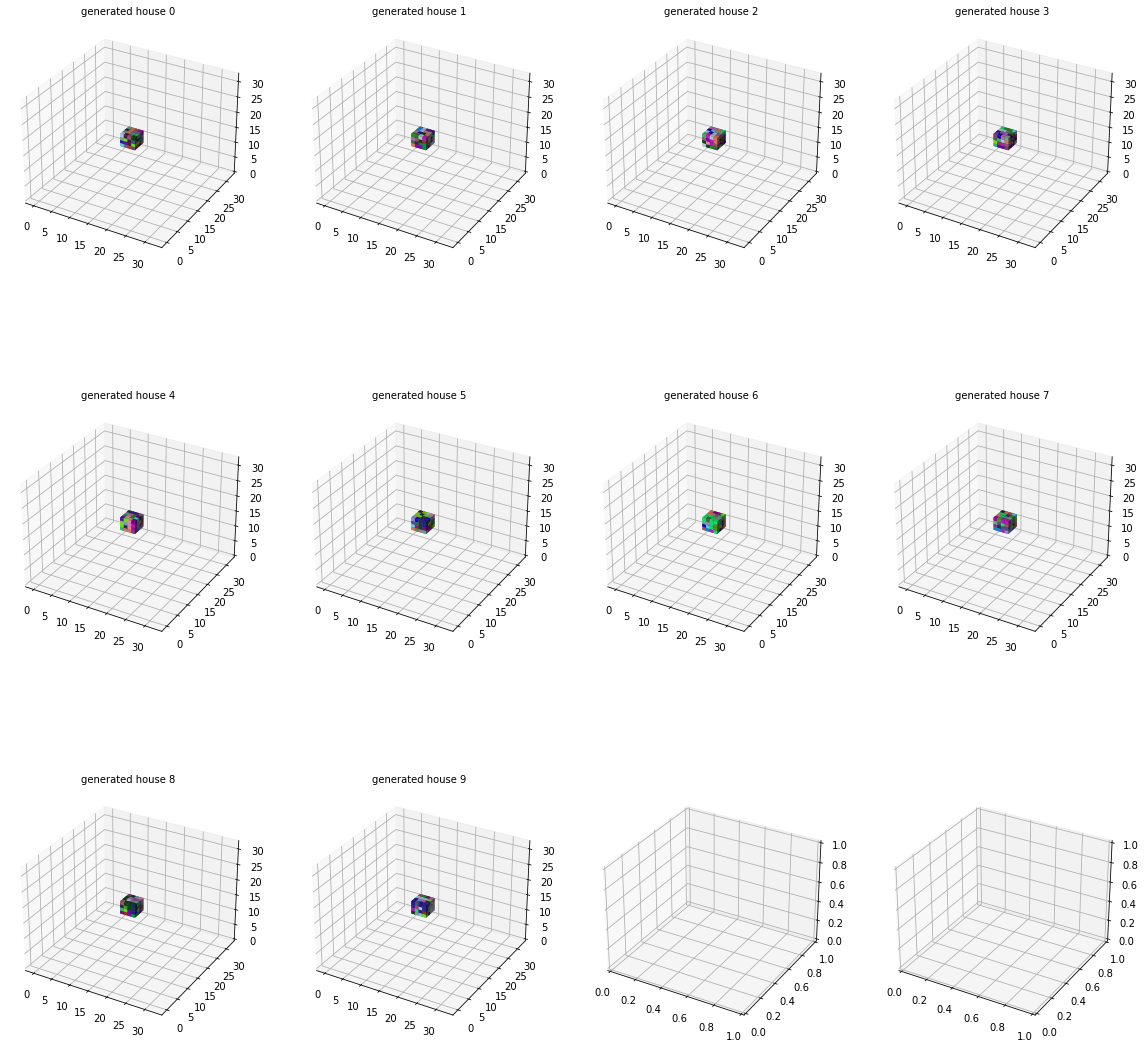

In [230]:
fig = state_to_graph(fake_houses.detach(), embedding.weight)